# QU CBE Introduction to Python Workshop - Advanced Economic Applications

**Mohammed Ait Lahcen, Department of Finance and Economics, College of Business and Economics, Qatar University**

## Markov Chains

In [1]:
import numpy as np
from numba import njit
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

### Example

Consider Hamilton's stochastic kernel (transition matrix) $p_H$ where $S = \{NG,MR,SR\}$, $NG$ corresponds to normal growth, $MR$ to mild recession and $SR$ to severe recession: 

In [2]:
p_H = np.array([[0.971,0.029,0],[0.145,0.778,0.077],[0,0.508,0.492]])
p_H

array([[0.971, 0.029, 0.   ],
       [0.145, 0.778, 0.077],
       [0.   , 0.508, 0.492]])

In [3]:
# For example probability of entering a mild recession given that the economy is in a normal growth state is
p_H[0,1]

0.029

### Sampling

We would like to generate a sample path of the economy using $p_H$.

In [4]:
def sample(ϕ):
    """
    Returns i with probability ϕ(i) where ϕ is the probability distribution (array)
    """
        
    a = 0
    
    U = np.random.uniform(0,1)  # Draws from Uniform
    
    for i in range(len(ϕ)):
        
        if a < U <= a + ϕ[i]:
        
            return i   # Inverse of the CDF (index of the state)
        
        else: a = a + ϕ[i]    # Goes up the CDF


def sample_path(x,p,k):
    """
    Takes initial state x and stochastic kernel p and generates a sample path of length k
    """
    
    path = np.empty(k, dtype=int)
    
    for i in range(k):
        path[i] = x
        x = sample(p[x])
        
    return path

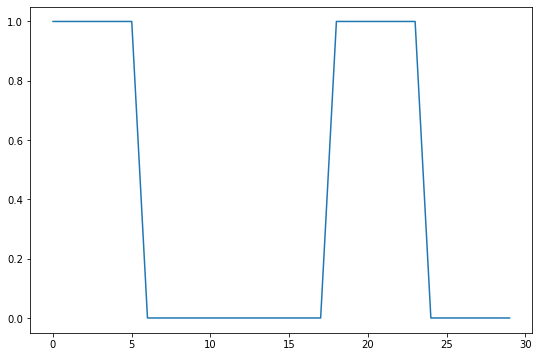

In [5]:
x_0 = sample(np.array([0,1,0], dtype=int))
s = sample_path(x_0,p_H,30)

plt.figure(figsize=(9,6))
plt.plot(s)
plt.show()
plt.close()

### Marginal distribution

Two ways to calculate the marginal distribution of $X_{j+k}$ given the marginal distribution of $X_j$ and the stochastic kernel p:
- Monte Carlo simulation
- Recursion using Markov operator: $\psi_{j+k} = \psi_j M^k$ where $M$ is the Markov operator (i.e. transition matrix) and $\psi_j$ is the marginal distribution of $X_j$

In [6]:
def marginal_dist_mc(ψ,p,k,n):
    """
    Returns the marginal (unconditional) distribution ψ_t+k of x_t+k given distribution ψ_t of initial state x_t
    and stochastic kernel p using n samples (monte carlo simulation)
    """
    
    cross_section = np.empty(n)
    
    mdist = np.empty(len(p))
    
    for i in range(n):  # iterate over number of sample paths
        
        # generate a sample path of length k with initial state x
        
        x_tk = sample(ψ)
        
        for j in range(k):
            x_tk = sample(p[x_tk])            
        
        cross_section[i] = x_tk  # extract the last element and store it
        
    for i in range(len(p)):
        mdist[i] = np.mean(cross_section == i)  # calculate the frequency of each state
        
    return mdist

In [7]:
p = np.array([[0.4,0.6],[0.2,0.8]])

In [8]:
# Calculate marginal distribution ψ_3 of X_{3} given ψ_0 and p above
# Using Markov operator (matrix post-multiplication)
ψ_0 = np.array([0.7,0.3])
ψ_3 = ψ_0 @ (np.linalg.matrix_power(p, 3))
ψ_3

array([0.2536, 0.7464])

In [9]:
# Using Monte Carlo
marginal_dist_mc(ψ_0,p,3,10000)

array([0.2491, 0.7509])

### Stationary distribution

Under some conditions on $p$, this should converge to the unique stationary distribution $\psi^*: \psi^* = \psi^* p $ as the sample becomes large

In [10]:
ψ_0 = np.array([1, 0])
marginal_dist_mc(ψ_0,p,1000,1000)

array([0.254, 0.746])

In [11]:
ψ_0 = np.array([1,0, 0])
marginal_dist_mc(ψ_0,p_H,1000,1000)

array([0.808, 0.163, 0.029])

One can also calculate the stationary distribution by iterating over the Markov operator (the transition matrix)

In [12]:
def solve_stationary_dist(ψ_init,p):
    """
    Returns the stationary (marginal/unconditional) distribution of a Markov chain given initial distribution ψ 
    and transition matrix (stochastic kernel) p
    """
    
    tol = 1e-8
    iter_count = 0
    error = tol + 1
    max_iter = 1000
    
    ψ = ψ_init
    
    while error > tol and iter_count < max_iter:
        iter_count += 1
        ψ_new = ψ @ p
        error = np.max(np.abs(ψ_new - ψ))
        ψ = ψ_new
    
    if iter_count == max_iter:
        print('Failed to converge!!!')
        
    elif iter_count < max_iter:
        print(f'Converged in {iter_count} iterations!')
    
    return ψ

In [13]:
solve_stationary_dist([0.1, 0.9],p)

Converged in 12 iterations!


array([0.25, 0.75])

In [14]:
solve_stationary_dist([0.1, 0,0.9],p_H)

Converged in 104 iterations!


array([0.81279995, 0.16256004, 0.02464001])

A third option to solve for the unique stationary distribution is to solve the system of linear equations: $\psi^* (\mathcal{I} - p) = 0$. The problem is that 0 is always a solution which means the solver can get stuck there. It also doesn't garantee that $\psi^*$ is a probability distribution!

In [15]:
ψ_star = optimize.root(lambda x: x @ (np.identity(p.shape[0]) - p),x0 = [0.1,0.9], method='df-sane').x
ψ_star

array([0.25, 0.75])

In [16]:
ψ_star = optimize.root(lambda x: x @ (np.identity(p_H.shape[0]) - p_H),x0 = [0.1, 0.1,0.8], method='df-sane').x
ψ_star

array([0.8128 , 0.16256, 0.02464])

One can impose that the elements of $\psi$ sum to 1 using:
$$
\mathbb{1}_N = \psi^* (\mathbf{I}_N - p + \mathbb{1}_{N \times N}) 
$$
which can be rewritten in the form $Ax = b$ as
$$
(\mathbf{I}_N - p + \mathbb{1}_{N \times N})^T {\psi^*}^T = \mathbb{1}_N^T
$$
and solved as $x = A^{-1} b$

In [17]:
ψ_star = np.linalg.inv(np.transpose(np.identity(p.shape[0]) - p + np.ones(p.shape))) @ np.ones(p.shape[0]).T 
ψ_star

array([0.25, 0.75])

In [18]:
ψ_star = np.linalg.inv(np.transpose(np.identity(p_H.shape[0]) - p_H + np.ones(p_H.shape))) @ np.ones(p_H.shape[0]).T 
ψ_star

array([0.8128 , 0.16256, 0.02464])

### Probability of a given path

In [19]:
def path_prob(p,ψ,X):
    """
    Returns the probability of a path X given kernel p and initial distribution ψ
    """
    
    prob = ψ[X[0]]
    
    for t in range(len(X) - 1):
        prob = prob * p[X[t],X[t+1]]
    
    return prob

In [20]:
X = np.array([0,1,0]) # Path in the form of indices
ψ_init = np.array([0.2,0.2,0.6]) # probability distribution of initial state
path_prob(p_H, ψ_init,X)

0.0008410000000000001

### Calculating expectations

#### Case with one Markov chain

In [104]:
# Let V be the value function that depends on two state variables u and y each with two states (high, low)
V = np.array([[0.5,1],[0,0.75]])

# Assume following stochastic kernel for exogenous state variable y
P_y = np.array([[0.4,0.6],[0.2,0.8]])

In [106]:
# Calculating the expectation of V using Markov operator notation
EV = P_y @ V
EV
# Each row is the conditional expectation of V (conditional on y_t)

array([[0.2 , 0.85],
       [0.1 , 0.8 ]])

In [118]:
# check by calculating expected V(.,u_h) conditional on previous state being y_h
P_y[0,0] * V[0,0] + P_y[0,1] * V[1,0]

0.2

In [112]:
# Another way of thinking about it is the following
# Assume y_0 = y_h. This means marginal distribution of y_0 is 
ψ_0 = np.array([1,0])

# Now we can calculate marginal distributon of y_1 given ψ_0 and kernel P_y
ψ_1 =  ψ_0 @ P_y
ψ_1

array([0.4, 0.6])

In [119]:
# Now that we have the marginal distribution of y_1 conditional on y_0 = y_h we can calculate expectated V conditional on y_0 = y_h
ψ_1 @ V

# This is the first row of the expected V calculated above
# Because V is also a function of u it's a vector

array([0.2 , 0.85])

#### Case with two Markov chains

In [22]:
# Let V be the value function that depends on three state variables i, y and u each with two states (high, low)
# Both i and y are independent Markov processes
# V(i,y,u) can be represented as a Tensor with shape (2x2x2)
V = np.array([[[0.3,0.7],[0,0.5]],[[0.7,1],[0.25,0.75]]])
V

array([[[0.3 , 0.7 ],
        [0.  , 0.5 ]],

       [[0.7 , 1.  ],
        [0.25, 0.75]]])

In [23]:
# Assume following stochastic kernels for exogenous state variables y and i
P_i = np.array([[0.9,0.1],[0.3,0.7]])
P_y = np.array([[0.6,0.4],[0.2,0.8]])

We would like to calculate $\mathbb{E}(V)$ which is going to have the same dimension as $V$. There are at least two possible ways:
- Using a loop (use law of iterated expectations)
- Using matrix (or tensor) multiplications with Markov operators

Below we try the first way as it is more transparent and can be easily jitted using numba for higher performance.

In [24]:
# Using loop

EV = np.empty_like(V)

ni = len(P_i[:,0]) # number of states of i
ny = len(P_y[:,0]) # number of states of y

# Use law of iterated expectations (order does not matter)
# Calculate expectation over distribution of y given i
for j_i in range(ni):
    
    EV[j_i,:,:] = P_y @ V[j_i,:,:]

# Next, calculate expectations over distribution of y
for j_y in range(ny):
    
    EV[:,j_y,:] = P_i @ EV[:,j_y,:]
    
EV

array([[[0.214, 0.648],
        [0.088, 0.566]],

       [[0.418, 0.816],
        [0.256, 0.722]]])

In [25]:
# Check by calculating expected V(.,.,u_h) conditional on previous state being y_h, i_h

P_i[0,0] * (P_y[0,0] * V[0,0,0] + P_y[0,1] * V[0,1,0]) + P_i[0,1] * (P_y[0,0] * V[1,0,0] + P_y[0,1] * V[1,1,0])

0.21400000000000002

In [26]:
# Check by calculating expected V(.,.,u_l) conditional on previous state being i_h and y_l

P_i[0,0] * (P_y[1,0] * V[0,0,1] + P_y[1,1] * V[0,1,1]) + P_i[0,1] * (P_y[1,0] * V[1,0,1] + P_y[1,1] * V[1,1,1])

0.5660000000000001